In [3]:
import sccoda

In [4]:
import seaborn 

In [5]:
import warnings
import numpy as np
import pandas as pd 
import scanpy as sc
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [6]:
import anndata as ad

In [7]:
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

In [8]:
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
import sccoda.util.comp_ana as ana
import sccoda.datasets as scd

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
from typing import Dict

import numpy as np
import pandas as pd
from anndata import AnnData


def score_seeds(
    adata: AnnData,
    seed_marker_genes: Dict[str, Dict[str, list]],
    layer: str = "log1p_norm",
    cutoff_sum_pos_marker_expression: float = 0.1,
    cutoff_sum_neg_marker_expression: float = 0,
) -> pd.Series:
    """Label seed cell types based on input pos/neg marker gene expression"""
    
    def _score_ct(adata, seed_marker_genes, layer, cutoff_sum_pos_marker_expression):
        tmp_df = pd.DataFrame(index=adata.obs_names)
        
        for cell_type, markers in seed_marker_genes.items():
            positive_conditions = []
            negative_conditions = []
            
            for positive_markers_list in markers['positive']:
                positive_condition = np.ravel(adata[:, adata.var_names.isin(positive_markers_list)].layers[layer].sum(1)) > cutoff_sum_pos_marker_expression
                positive_conditions.append(positive_condition)
            
            for negative_markers_list in markers['negative']:
                negative_condition = ~(np.ravel(adata[:, adata.var_names.isin(negative_markers_list)].layers[layer].sum(1)) > cutoff_sum_neg_marker_expression)
                negative_conditions.append(negative_condition)
            
            combined_positive_condition = np.all(positive_conditions, axis=0)
            combined_negative_condition = np.all(negative_conditions, axis=0)
            
            condition = combined_positive_condition & combined_negative_condition
            tmp_df[f"tmp_{cell_type}"] = np.where(condition, cell_type, "unknown")
        
        return tmp_df

    
    def _combine_ct(row):
        for ct in seed_ct:
            if row[ct] != 'unknown':
                return row[ct]
        return 'unknown'

    seed_df = _score_ct(adata, seed_marker_genes, layer, cutoff_sum_pos_marker_expression)
    seed_ct = [f"tmp_{ct}" for ct in seed_marker_genes.keys()]
    
    return seed_df.apply(_combine_ct, axis=1)

In [77]:
adata = sc.read_h5ad("adata_neighbors.h5ad")

In [78]:
adata.layers["counts"] = adata.X
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [79]:
frac_by_condition = (
    adata.obs.groupby(["condition", "sample_id"])
    .apply(lambda x: x.value_counts("cell_type", normalize=False))
    .reset_index(name="n_cells")
    .assign(condition=lambda x: x["condition"].astype(str))
)

In [80]:
frac_by_condition

,condition,sample_id,cell_type,n_cells
0,10mix,10mix_ICI1,SLEC_Effector,2093
1,10mix,10mix_ICI1,SLEC_Ifn,1111
2,10mix,10mix_ICI1,SLEC_Intermediate,977
3,10mix,10mix_ICI1,SLEC_Progenitor,543
4,10mix,10mix_ICI1,MPEC_Progenitor,519
...,...,...,...,...
67,GF,GF_ICI2_plus,MPEC_Intermediate,326
68,GF,GF_ICI2_plus,MPEC_Effector,310
69,GF,GF_ICI2_plus,MPEC_Progenitor,230
70,GF,GF_ICI2_plus,SLEC_Plastic,88


In [81]:
#frac_by_condition.to_csv("frac_by_condition.csv")

In [82]:
frac_pivot = (
    frac_by_condition.pivot(
        index=["sample_id", "condition"],
        columns="cell_type",
        values="n_cells",
    )
    .reset_index()
    #.drop(columns="other")
)

In [83]:
frac_pivot

cell_type,sample_id,condition,SLEC_Ifn,MPEC_Progenitor,MPEC_Intermediate,MPEC_Effector,SLEC_Plastic,SLEC_Effector,SLEC_Intermediate,SLEC_Progenitor,SLEC_Terminal
0,10mix_ICI1,10mix,1111,519,366,261,74,2093,977,543,498
1,10mix_ICI2,10mix,673,625,136,207,101,963,310,665,699
2,11mix_ICI1,11mix,1388,224,240,488,75,2034,1037,614,104
3,11mix_ICI2,11mix,1298,671,202,927,150,1479,88,396,104
4,GF_ICI1,GF,952,396,510,259,71,1010,812,406,458
5,GF_ICI1_plus,GF,1280,190,248,240,61,859,1228,291,118
6,GF_ICI2,GF,611,654,340,342,86,1105,106,244,59
7,GF_ICI2_plus,GF,1339,230,326,310,88,1758,777,679,68


In [84]:
data_all = dat.from_pandas(
    frac_pivot, covariate_columns=["condition","sample_id"]
)

In [85]:
data_all.obs["condition"] = pd.Categorical(
    data_all.obs["condition"], categories=["10mix","11mix","GF"]
)


In [86]:
data_all._sanitize()

In [87]:
data = data_all
feature_name="sample_id"
sample_sums = np.sum(data.X, axis=1, keepdims=True)
X = data.X/sample_sums
value_name = "Proportion"
count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
merge(data.obs[feature_name], left_index=True, right_index=True)
plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)

In [88]:
plot_df['condition'] = plot_df['sample_id'].apply(lambda x: '10mix' if '10mix_ICI' in x else ('11mix' if '11mix_ICI' in x else 'GF'))

In [89]:
plot_df['treatment'] = plot_df['sample_id'].apply(
    lambda x: 'naive' if x in ['GF_ICI1_plus', 'GF_ICI2_plus'] else 'treated'
)

In [90]:
plot_df

,sample_id,Cell type,Proportion,condition,treatment
0,10mix_ICI1,SLEC_Ifn,0.172462,10mix,treated
1,10mix_ICI2,SLEC_Ifn,0.153688,10mix,treated
2,11mix_ICI1,SLEC_Ifn,0.223727,11mix,treated
3,11mix_ICI2,SLEC_Ifn,0.244214,11mix,treated
4,GF_ICI1,SLEC_Ifn,0.195322,GF,treated
...,...,...,...,...,...
67,11mix_ICI2,SLEC_Terminal,0.019567,11mix,treated
68,GF_ICI1,SLEC_Terminal,0.093968,GF,treated
69,GF_ICI1_plus,SLEC_Terminal,0.026135,GF,naive
70,GF_ICI2,SLEC_Terminal,0.016634,GF,treated


In [91]:
#plot_df.to_csv("plot_df.csv")

## Interferon positive cells 

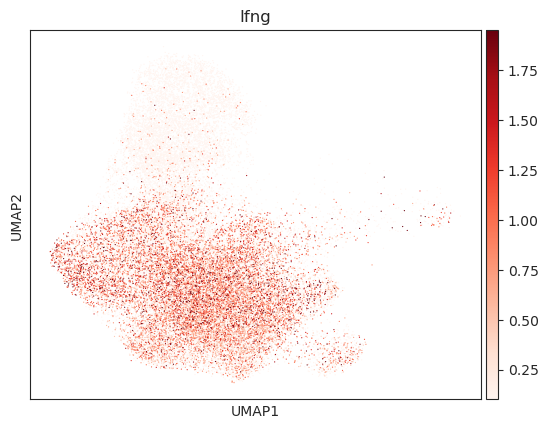

In [92]:
sc.pl.umap(adata, color="Ifng", vmax="p99",vmin=0.1, cmap="Reds")

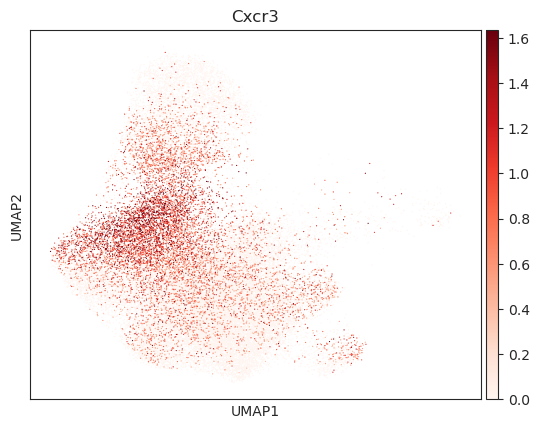

In [93]:
sc.pl.umap(adata, color="Cxcr3", vmax="p99", cmap="Reds")

In [94]:
adata.obs["cell_type_seed"] = score_seeds(
    adata,
    {
        "Interferon": {
            "positive": [['Ifng']],
            "negative": [[""]],
        },
        "Cxcr3": {
            "positive": [['Cxcr3']],
            "negative": [[""]],
        }
   },
    cutoff_sum_pos_marker_expression=0.25,
)

In [95]:
adata.obs.cell_type_seed.value_counts()

cell_type_seed
unknown       21085
Interferon    13140
Cxcr3          6626
Name: count, dtype: int64

In [106]:
adata_interferon = adata[adata.obs["cell_type_seed"]=="Interferon"]

In [107]:
adata_interferon

View of AnnData object with n_obs × n_vars = 13140 × 15819
    obs: 'adata_name', 'condition', 'batch_id', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rna_leiden', 'rna_leiden_05', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_top_20', 'is_outlier_mito', 'is_outlier', 'protein_leiden', 'joint_leiden', 'joint_leiden_15', 'cell_type', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'cell_type2', 'leiden', 'louvain', 'cell_type_seed'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_t

In [108]:
adata

AnnData object with n_obs × n_vars = 40851 × 15819
    obs: 'adata_name', 'condition', 'batch_id', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rna_leiden', 'rna_leiden_05', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_top_20', 'is_outlier_mito', 'is_outlier', 'protein_leiden', 'joint_leiden', 'joint_leiden_15', 'cell_type', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'cell_type2', 'leiden', 'louvain', 'cell_type_seed'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type2_col

In [113]:
adata.var

,gene_ids,feature_types,genome,pattern,read,sequence,n_cells,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
Xkr4,ENSMUSG00000051951,Gene Expression,mm10,,,,29,False,False,16,0.000230,0.000230,99.965969,10.798918,2.468008
Mrpl15,ENSMUSG00000033845,Gene Expression,mm10,,,,28471,False,False,19119,0.303382,0.264962,59.335120,14263.833008,9.565553
Lypla1,ENSMUSG00000025903,Gene Expression,mm10,,,,25886,False,False,17217,0.268973,0.238208,63.380551,12646.036133,9.445178
Tcea1,ENSMUSG00000033813,Gene Expression,mm10,,,,41450,False,False,28706,0.528085,0.424016,38.944189,24828.439453,10.119785
Rgs20,ENSMUSG00000002459,Gene Expression,mm10,,,,45,False,False,30,0.000434,0.000434,99.936192,20.425707,3.064591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PD1_TotalSeqC,PD1,Antibody Capture,,5PNNNNNNNNNN(BC),R2,GAAAGTCAAAGCACT,70791,False,False,45896,4.102825,1.629794,2.382168,192898.859375,12.169927
CD69_TotalSeqC,CD69,Antibody Capture,,5PNNNNNNNNNN(BC),R2,TTGTATTCCGCCATT,68795,False,False,44892,3.282193,1.454465,4.517611,154315.515625,11.946761
CD44_TotalSeqC,CD44,Antibody Capture,,5PNNNNNNNNNN(BC),R2,TGGCTTCAGGTCCTA,72590,False,False,47016,6.647048,2.034320,0.000000,312517.843750,12.652420
ICOS_TotalSeqC,ICOS,Antibody Capture,,5PNNNNNNNNNN(BC),R2,CGCGCACCCATTAAA,72555,False,False,47016,4.629947,1.728100,0.000000,217681.109375,12.290792


In [ ]:
sc.pl.umap(adata, color=["Gzmk", "Il7r","Layn"],  vmax="p99", cmap="Reds")

In [98]:
adata[adata.obs["cell_type"]=="SLEC_Ifn"]

View of AnnData object with n_obs × n_vars = 8652 × 15819
    obs: 'adata_name', 'condition', 'batch_id', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rna_leiden', 'rna_leiden_05', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_top_20', 'is_outlier_mito', 'is_outlier', 'protein_leiden', 'joint_leiden', 'joint_leiden_15', 'cell_type', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'cell_type2', 'leiden', 'louvain', 'cell_type_seed'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_ty

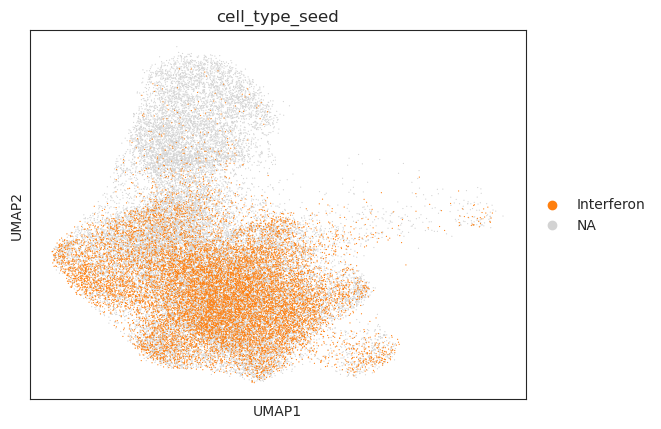

In [103]:
sc.pl.umap(adata, color="cell_type_seed", groups="Interferon")

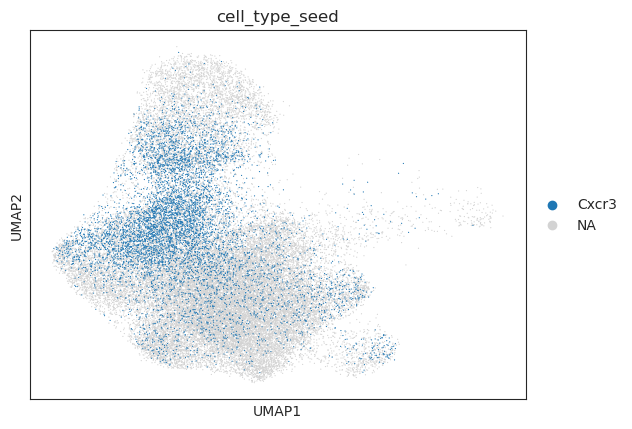

In [104]:
sc.pl.umap(adata, color="cell_type_seed", groups="Cxcr3")

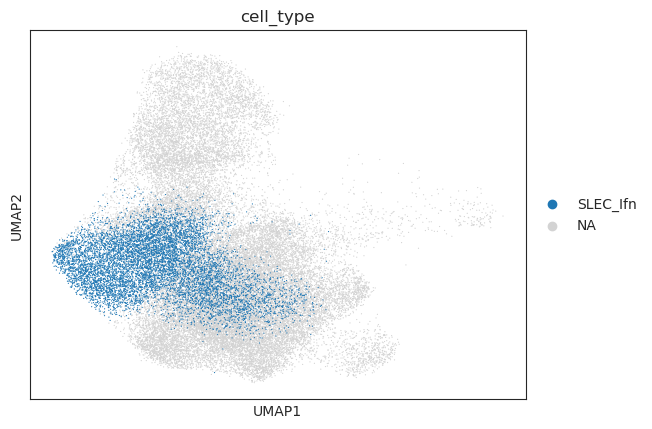

In [100]:
sc.pl.umap(adata, color="cell_type", groups="SLEC_Ifn")

In [101]:
adata_interferon

View of AnnData object with n_obs × n_vars = 0 × 15819
    obs: 'adata_name', 'condition', 'batch_id', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'rna_leiden', 'rna_leiden_05', 'is_outlier_counts', 'is_outlier_genes', 'is_outlier_top_20', 'is_outlier_mito', 'is_outlier', 'protein_leiden', 'joint_leiden', 'joint_leiden_15', 'cell_type', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'cell_type2', 'leiden', 'louvain', 'cell_type_seed'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type2

In [102]:
#adata_interferon.write_h5ad("adata_interferon.h5ad")

In [56]:
adata = adata_interferon

In [57]:
frac_by_condition = (
    adata.obs.groupby(["condition", "sample_id"])
    .apply(lambda x: x.value_counts("cell_type", normalize=False))
    .reset_index(name="n_cells")
    .assign(condition=lambda x: x["condition"].astype(str))
)

In [58]:
frac_pivot = (
    frac_by_condition.pivot(
        index=["sample_id", "condition"],
        columns="cell_type",
        values="n_cells",
    )
    .reset_index()
    #.drop(columns="other")
)

In [59]:
data_all = dat.from_pandas(
    frac_pivot, covariate_columns=["condition","sample_id"]
)

In [60]:
data_all.obs["condition"] = pd.Categorical(
    data_all.obs["condition"], categories=["10mix","11mix","GF"]
)


In [61]:
data_all._sanitize()

In [62]:
data = data_all
feature_name="sample_id"
sample_sums = np.sum(data.X, axis=1, keepdims=True)
X = data.X/sample_sums
value_name = "Proportion"
count_df = pd.DataFrame(X, columns=data.var.index, index=data.obs.index).\
merge(data.obs[feature_name], left_index=True, right_index=True)
plot_df = pd.melt(count_df, id_vars=feature_name, var_name="Cell type", value_name=value_name)

In [63]:
plot_df['condition'] = plot_df['sample_id'].apply(lambda x: '10mix' if '10mix_ICI' in x else ('11mix' if '11mix_ICI' in x else 'GF'))

In [64]:
plot_df['treatment'] = plot_df['sample_id'].apply(
    lambda x: 'naive' if x in ['GF_ICI1_plus', 'GF_ICI2_plus'] else 'treated'
)

In [67]:
plot_df.rename(columns={'Cell type':"cell_type"}, inplace = True)

In [69]:
plot_df.cell_type.unique()

array(['SLEC_Ifn', 'MPEC_Progenitor', 'MPEC_Intermediate',
       'MPEC_Effector', 'SLEC_Plastic', 'SLEC_Effector',
       'SLEC_Intermediate', 'SLEC_Progenitor', 'SLEC_Terminal'],
      dtype=object)

In [70]:
frac_by_condition.to_csv("frac_by_condition_INF.csv")

In [71]:
plot_df.to_csv("plot_df_INF.csv")